분할 가능한 균형 클러스터링 최적화 시작
입력 데이터 shape: torch.Size([17, 3])
Set parameter Username
Set parameter LicenseID to value 2693211
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2693068
Academic license 2693068 - for non-commercial use only - registered to 20___@kangwon.ac.kr
Gurobi WLS 라이센스가 성공적으로 적용되었습니다.
Set parameter OutputFlag to value 1
Set parameter TimeLimit to value 300
Set parameter MIPGap to value 0.1
Set parameter PoolSearchMode to value 2
Set parameter PoolSolutions to value 10
Set parameter PoolGap to value 0.1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 3 4100 4-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300
MIPGap  0.1
PoolSearchMode  2
PoolGap  0.1

Academic license 2693068 - for non-commercial use only - registered to 20___@kangwon.ac.kr
Optimize a model with 692 rows,

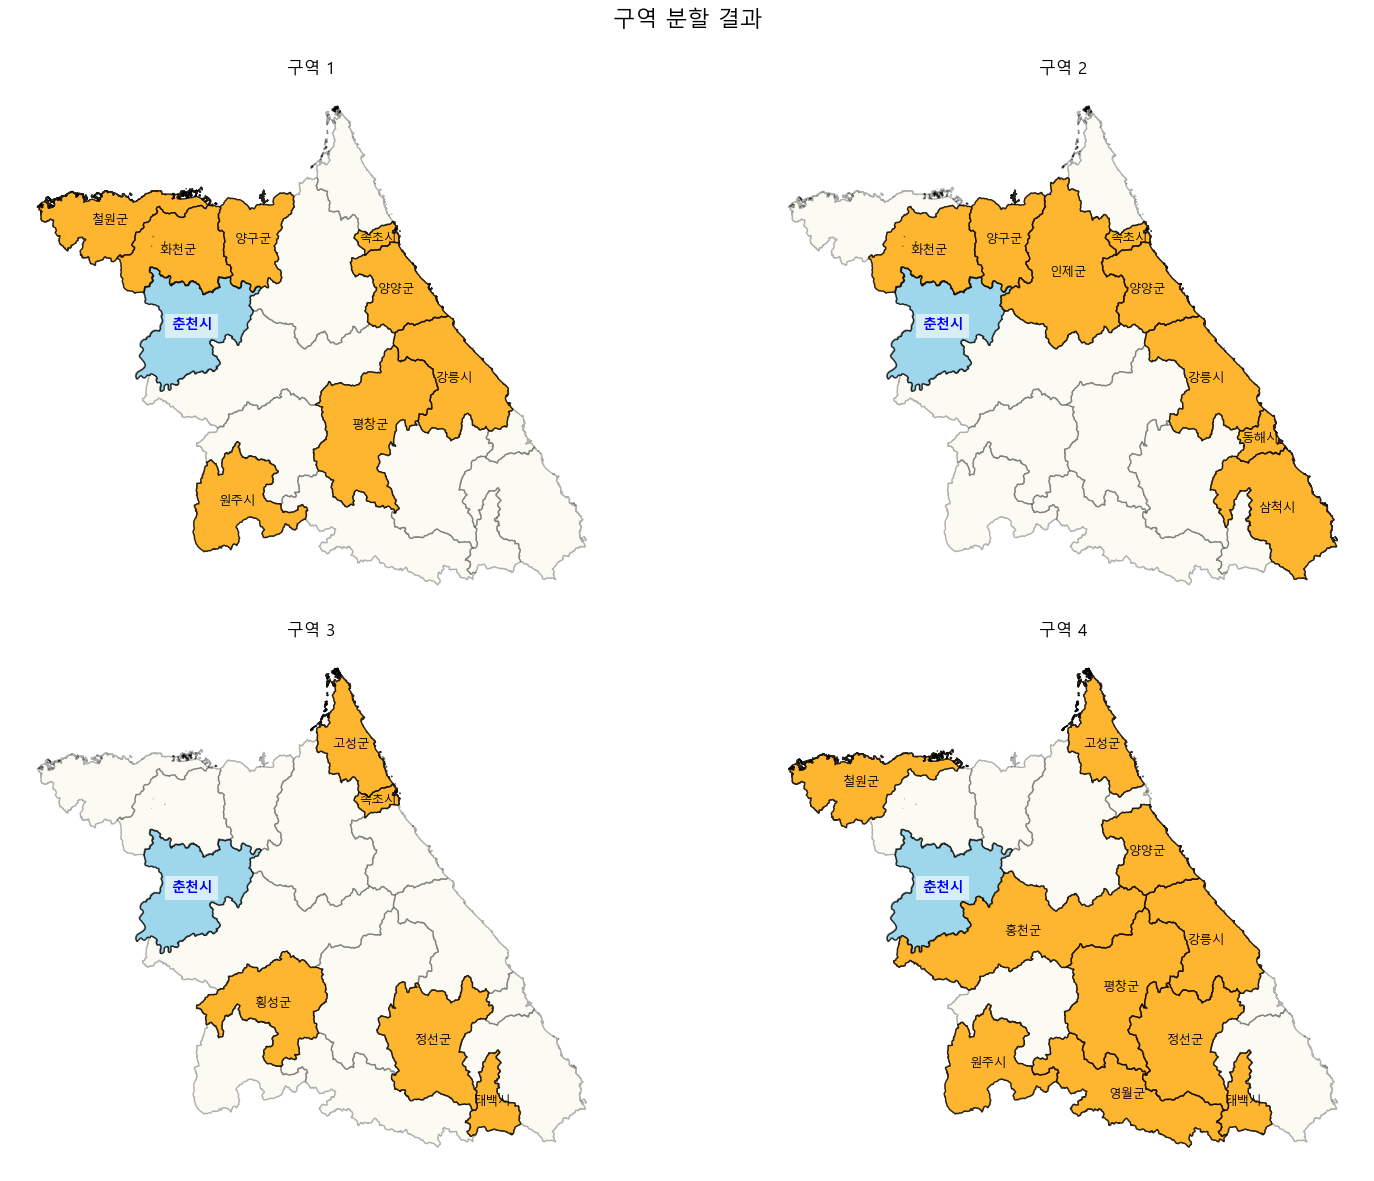


클러스터별 할당된 수요/공급 행렬 + 거리 행렬 (차고지 포함)

[클러스터 1]
▶ 할당된 수요/공급 행렬:
    노드  0: [   0,    0,    0]
    노드  0: [-220,  130,    0]
    노드  1: [ -50,    0,   60]
    노드  4: [  20,    0,    0]
    노드  9: [  90,  170,    0]
    노드 11: [   0,   40,    0]
    노드 12: [   0, -100,    0]
    노드 13: [   0, -240,  -60]
    노드 16: [ 160,    0,    0]

▶ 거리 행렬:
    [0.00, 0.00, 0.84, 0.22, 0.15, 0.15, 0.78, 0.30, 0.12]
    [0.00, 0.00, 0.84, 0.22, 0.15, 0.15, 0.78, 0.30, 0.12]
    [0.84, 0.84, 0.00, 0.65, 0.90, 2.43, 1.87, 1.28, 0.53]
    [0.22, 0.22, 0.65, 0.00, 1.44, 2.21, 1.18, 0.67, 0.17]
    [0.15, 0.15, 0.90, 1.44, 0.00, 2.11, 1.43, 1.50, 1.24]
    [0.15, 0.15, 2.43, 2.21, 2.11, 0.00, 0.61, 1.19, 2.11]
    [0.78, 0.78, 1.87, 1.18, 1.43, 0.61, 0.00, 0.44, 1.43]
    [0.30, 0.30, 1.28, 0.67, 1.50, 1.19, 0.44, 0.00, 0.74]
    [0.12, 0.12, 0.53, 0.17, 1.24, 2.11, 1.43, 0.74, 0.00]

[클러스터 2]
▶ 할당된 수요/공급 행렬:
    노드  0: [   0,    0,    0]
    노드  1: [   0,  340,    0]
    노드  2: [ -10, -370,  480]
    노드  4:

In [2]:
import torch
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import random
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.font_manager as fm
import math

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows 기본 한글 폰트
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 기호 깨짐 방지

# 군집 내 거리 비슷하게
# 최대 적재량 설정 (한 노드의 공급량, 수요량 제한(수요량 제한은 더 생각해보기))
# 클러스터링 시각화


# 파라미터 조정
num_clusters = 4 # 클러스터 개수
max_solutions = 10 # 구할 솔루션의 최대 개수
solution_ratio = 0.1 # 다수 해를 구할 때 최적 솔루션 목적함수 값과의 차이 허용치 (0.1 = 10% 이내로 차이나는 솔루션만 저장)
limit =  10_000_000 # 적재 한도 (수요량, 공급량 제한 / 수요량 분할 범위 : -limit ~ 0 / 공급량 분할 범위 : 0 ~ limit)
            # 주의사항 : 모든 노드의 공급량이 num_clusters * limit 이하, 수요량이 -(num_clusters * limit) 이상이어야 함.

'''
            *** 거리 메트릭 설명 ***

TPC (Total Pairwise Cost) : 전체 노드 쌍 거리 총합
MFC (Mean Facility Cost) : 클러스터 중심(시설)까지의 평균 거리
APC (Average Pairwise Cost) : 모든 노드쌍 거리의 평균
MPC (Maximum Pairwise Cost) : 가장 먼 두 노드 사이 거리 (지름)
중심점 거리 : 중심점(centroid)에서 모든 노드까지의 평균 거리
지름 (Diameter) : 네트워크에서 가장 먼 두 노드 간 거리
반지름 (Radius) : 중심점에서 가장 먼 노드까지의 거리
실루엣 점수 : 클러스터 품질: 음수 → 군집 경계가 불분명
중심점 노드 : 가장 중앙에 있는 노드 (centroid node)
'''


# 노드별 수요/공급 데이터 (6개 노드로 축소)
# 노드별 수요/공급 데이터
# 노드별 수요/공급 데이터 => 노드 0(춘천, 차고지) 제외
fixed_net_demand = torch.tensor([
    [-220,  130,   30],
    [-430,  340,   60],
    [ -10, -370,  480],
    [ 390, -430, -440],
    [  20, -110, -450],
    [-330, -230,  220],
    [ 220,  280,  260],
    [ 290,  490,   40],
    [-490, -480, -180],
    [  90,  480,  -50],
    [ 360, -340,  -30],
    [ -10,   40,  340],
    [ 120, -280,  140],
    [ 400, -240, -390],
    [-220,  130, -360],
    [-380,  280,   20],
    [ 200,  310,  310]
], dtype=torch.float32)

# 노드 간 거리 행렬 => 노드 0(춘천, 차고지) 제외
dist_matrix = torch.tensor([
        [0.00, 1.27, 1.66, 1.41, 1.81, 1.75, 0.60, 0.20, 0.72, 0.70, 1.23, 1.56, 1.12, 1.22, 1.12, 2.02, 1.58],
        [1.27, 0.00, 0.47, 0.99, 0.65, 0.59, 1.34, 1.07, 1.17, 0.90, 0.68, 2.43, 1.87, 1.28, 1.10, 0.96, 0.53],
        [1.66, 0.47, 0.00, 0.54, 1.04, 0.14, 1.73, 1.46, 1.14, 1.29, 0.76, 2.82, 2.27, 1.68, 1.50, 1.36, 0.89],
        [1.41, 0.99, 0.54, 0.00, 1.64, 0.47, 1.89, 1.59, 0.64, 0.84, 0.52, 2.87, 2.49, 2.16, 1.98, 1.85, 1.42],
        [1.81, 0.65, 1.04, 1.64, 0.00, 1.18, 1.05, 1.38, 1.71, 1.44, 1.38, 2.21, 1.18, 0.67, 0.50, 0.25, 0.17],
        [1.75, 0.59, 0.14, 0.47, 1.18, 0.00, 1.84, 1.59, 1.08, 1.07, 0.78, 2.93, 2.37, 1.78, 1.60, 1.47, 1.02],
        [0.60, 1.34, 1.73, 1.89, 1.05, 1.84, 0.00, 0.34, 1.24, 0.87, 1.16, 1.23, 0.65, 0.64, 0.54, 1.09, 0.90],
        [0.20, 1.07, 1.46, 1.59, 1.38, 1.59, 0.34, 0.00, 0.95, 0.55, 0.85, 1.45, 0.87, 0.97, 0.83, 1.78, 1.19],
        [0.72, 1.17, 1.14, 0.64, 1.71, 1.08, 1.24, 0.95, 0.00, 0.29, 0.52, 2.24, 1.87, 1.97, 1.86, 1.99, 1.51],
        [0.70, 0.90, 1.29, 0.84, 1.44, 1.07, 0.87, 0.55, 0.29, 0.00, 0.31, 2.11, 1.43, 1.50, 1.28, 1.71, 1.24],
        [1.23, 0.68, 0.76, 0.52, 1.38, 0.78, 1.16, 0.85, 0.52, 0.31, 0.00, 2.62, 2.20, 1.97, 1.42, 1.66, 1.18],
        [1.56, 2.43, 2.82, 2.87, 2.21, 2.93, 1.23, 1.45, 2.24, 2.11, 2.62, 0.00, 0.61, 1.19, 1.49, 1.92, 2.11],
        [1.12, 1.87, 2.27, 2.49, 1.18, 2.37, 0.65, 0.87, 1.87, 1.43, 2.20, 0.61, 0.00, 0.44, 0.73, 1.55, 1.43],
        [1.22, 1.28, 1.68, 2.16, 0.67, 1.78, 0.64, 0.97, 1.97, 1.50, 1.97, 1.19, 0.44, 0.00, 0.31, 0.75, 0.74],
        [1.12, 1.10, 1.50, 1.98, 0.50, 1.60, 0.54, 0.83, 1.86, 1.28, 1.42, 1.49, 0.73, 0.31, 0.00, 0.57, 0.55],
        [2.02, 0.96, 1.36, 1.85, 0.25, 1.47, 1.09, 1.78, 1.99, 1.71, 1.66, 1.92, 1.55, 0.75, 0.57, 0.00, 0.43],
        [1.58, 0.53, 0.89, 1.42, 0.17, 1.02, 0.90, 1.19, 1.51, 1.24, 1.18, 2.11, 1.43, 0.74, 0.55, 0.43, 0.00]
    ], dtype=torch.float32)


def print_matrix_form(allocation, fixed_net_demand, dist_matrix, num_clusters=4):
    """
    각 클러스터에 대해 다음을 출력:
    1. 수요/공급 행렬: 차고지 노드 [0,0,0] 항상 맨 위에 출력
    2. 거리 행렬: 차고지 노드와의 거리 포함 (depot_distances 반영)
    """
    n_nodes, n_items = fixed_net_demand.shape
    dist_np = dist_matrix.numpy()

    # 노드 0(춘천)과 나머지 노드 간 거리 (길이 17)
    depot_distances = [0.84,  0.16, 0.20, 0.22, 0.11, 0.21, 0.38, 0.61, 0.15,
                       0.12, 0.15, 0.78, 0.30, 0.44, 0.82, 0.12, 0.11]

    print("\n" + "=" * 90)
    print("클러스터별 할당된 수요/공급 행렬 + 거리 행렬 (차고지 포함)")
    print("=" * 90)

    for k in range(num_clusters):
        assigned_nodes = []
        assigned_matrix = []

        for i in range(n_nodes):
            if i in allocation:
                row = [0] * n_items
                has_value = False
                for j in range(n_items):
                    if j in allocation[i] and k in allocation[i][j]:
                        val = allocation[i][j][k]
                        row[j] = val
                        if abs(val) > 0:
                            has_value = True
                if has_value:
                    assigned_nodes.append(i)
                    assigned_matrix.append(row)

        print(f"\n[클러스터 {k + 1}]")
        if not assigned_nodes:
            print("  ▶ 소속 노드 없음 (빈 클러스터)")
            continue

        # ▶ 수요/공급 행렬: 항상 차고지 먼저
        print("▶ 할당된 수요/공급 행렬:")
        print(f"    노드  0: [   0,    0,    0]")  # 차고지
        for node_idx, row in zip(assigned_nodes, assigned_matrix):
            print(f"    노드 {node_idx:2d}: [{row[0]:4d}, {row[1]:4d}, {row[2]:4d}]")

        # ▶ 거리 행렬: 노드 0 포함
        print("\n▶ 거리 행렬:")
        all_nodes = [0] + assigned_nodes  # 차고지 포함한 노드 순서
        for i in all_nodes:
            row_vals = []
            for j in all_nodes:
                if i == 0 and j == 0:
                    row_vals.append("0.00")
                elif i == 0:
                    row_vals.append(f"{depot_distances[j-1]:.2f}")
                elif j == 0:
                    row_vals.append(f"{depot_distances[i-1]:.2f}")
                else:
                    row_vals.append(f"{dist_np[i][j]:.2f}")
            print(f"    [{', '.join(row_vals)}]")

def solve_divisible_balanced_clustering_gurobi(demand_data, dist_matrix, num_clusters=4, max_solutions=10, solution_ratio=0.1):

    demand_np = demand_data.numpy()
    dist_np = dist_matrix.numpy()
    n_nodes, n_items = demand_np.shape

       # --- 여기서부터 Gurobi WLS 라이센스 설정 코드를 삽입합니다. ---
    # 제공해주신 최신 양식에 따라 'WLSACCESSID' (S 하나) 및 'WLSSECRET' (S 하나)를 사용합니다.
    # 이 매개변수는 주로 자체 호스팅된 WLS Manager에 연결할 때 사용됩니다.
    # Gurobi 클라우드 WLS (Gurobi의 서버에 연결)를 사용하시는 경우 'WLSSACCESSID' (S 두 개)가 필요합니다.
    options = {
        "WLSACCESSID": "adfd0457-d15a-4933-9d1c-1728e40c50c5",
        "WLSSECRET": "57c6b5d8-2ea0-42de-ab31-419253a1ea00",
        "LICENSEID": 2693068,
    }

    try:
        # Gurobi 환경 설정
        # 'with' 구문을 사용하지 않고 직접 환경 객체와 모델 객체를 생성합니다.
        # 기존 함수 구조를 유지하면서 라이센스 설정만 변경하는 데 적합합니다.
        env = gp.Env(params=options)
        # 설정된 환경을 사용하여 모델 초기화
        model = gp.Model("divisible_balanced_clustering_mfc", env=env)
        print("Gurobi WLS 라이센스가 성공적으로 적용되었습니다.")
    except Exception as e:
        # 라이센스 오류 발생 시, 일반적인 모델 초기화 시도
        print(f"Gurobi WLS 라이센스 적용 중 오류 발생: {e}")
        print("WLS 라이센스 없이 모델을 초기화합니다. 라이센스 문제가 지속되면 Gurobi 지원팀에 문의해주세요.")
        model = gp.Model("divisible_balanced_clustering_mfc") # WLS 없이 초기화
    # --- 여기까지 WLS 라이센스 설정 코드입니다. ---

    model.setParam('OutputFlag', 1)
    model.setParam('TimeLimit', 300)
    model.setParam('MIPGap', solution_ratio)

    split, abs_split = {}, {}
    for i in range(n_nodes):
        for j in range(n_items):
            for k in range(num_clusters):
                if demand_np[i, j] > 0:
                    ub = min(10000000, int(demand_np[i, j]))
                    split[i, j, k] = model.addVar(vtype=GRB.INTEGER, lb=0, ub=ub, name=f"split_{i}_{j}_{k}")
                elif demand_np[i, j] < 0:
                    lb = max(-10000000, int(demand_np[i, j]))
                    split[i, j, k] = model.addVar(vtype=GRB.INTEGER, lb=lb, ub=0, name=f"split_{i}_{j}_{k}")
                else:
                    split[i, j, k] = model.addVar(vtype=GRB.INTEGER, lb=0, ub=0, name=f"split_{i}_{j}_{k}")

                abs_split[i, j, k] = model.addVar(vtype=GRB.INTEGER, lb=0, name=f"abs_split_{i}_{j}_{k}")
                model.addConstr(abs_split[i, j, k] >= split[i, j, k])
                model.addConstr(abs_split[i, j, k] >= -split[i, j, k])

    for i in range(n_nodes):
        for j in range(n_items):
            model.addConstr(gp.quicksum(split[i, j, k] for k in range(num_clusters)) == demand_np[i, j])

    for k in range(num_clusters):
        for j in range(n_items):
            model.addConstr(gp.quicksum(split[i, j, k] for i in range(n_nodes)) == 0)

    z = {}
    for i in range(n_nodes):
        for k in range(num_clusters):
            z[i, k] = model.addVar(vtype=GRB.BINARY, name=f"z_{i}_{k}")

    for i in range(n_nodes):
        for j in range(n_items):
            for k in range(num_clusters):
                model.addConstr(abs_split[i, j, k] <= 10000000 * z[i, k], name=f"link_split_z_{i}_{j}_{k}")

    # ✅ 클러스터당 최소 2개 노드 포함 제약 추가
    for k in range(num_clusters):
        model.addConstr(gp.quicksum(z[i, k] for i in range(n_nodes)) >= 2, name=f"min_two_nodes_cluster_{k}")

    mfc, dev_k = {}, {}
    for k in range(num_clusters):
        total_dist_k = model.addVar(vtype=GRB.CONTINUOUS, name=f"total_dist_k_{k}")
        node_count_k = model.addVar(vtype=GRB.CONTINUOUS, name=f"node_count_k_{k}")
        mfc[k] = model.addVar(vtype=GRB.CONTINUOUS, name=f"mfc_{k}")

        pairwise_dist_sum = gp.quicksum(
            gp.quicksum(dist_np[i][j] * z[i, k] * z[j, k] for j in range(n_nodes))
            for i in range(n_nodes)
        )
        model.addConstr(total_dist_k == pairwise_dist_sum)
        model.addConstr(node_count_k == gp.quicksum(z[i, k] for i in range(n_nodes)) + 1e-6)
        model.addConstr(mfc[k] == total_dist_k / node_count_k)

    avg_mfc = model.addVar(vtype=GRB.CONTINUOUS, name="avg_mfc")
    model.addConstr(avg_mfc == gp.quicksum(mfc[k] for k in range(num_clusters)) / num_clusters)

    for k in range(num_clusters):
        dev_k[k] = model.addVar(vtype=GRB.CONTINUOUS, name=f"dev_k_{k}")
        model.addConstr(dev_k[k] >= mfc[k] - avg_mfc)
        model.addConstr(dev_k[k] >= avg_mfc - mfc[k])

    split_penalty = [abs_split[i, j, k] for i in range(n_nodes) for j in range(n_items) for k in range(num_clusters)]

    alpha = 1.0
    beta = 0.1
    model.setObjective(
        alpha * gp.quicksum(dev_k[k] for k in range(num_clusters)) +
        beta * gp.quicksum(split_penalty),
        GRB.MINIMIZE
    )

    model.setParam(GRB.Param.PoolSearchMode, 2)
    model.setParam(GRB.Param.PoolSolutions, max_solutions)
    model.setParam(GRB.Param.PoolGap, solution_ratio)
    model.optimize()

    if model.status == gp.GRB.INFEASIBLE:
        print("모델 infeasible! IIS 계산 중...")
        model.computeIIS()
        model.write("model.ilp")
        model.write("model_iis.ilp")

    all_solutions = []
    for sol_idx in range(model.SolCount):
        model.setParam(GRB.Param.SolutionNumber, sol_idx)
        print(f"\n솔루션 {sol_idx+1}:")

        allocation = {}
        cluster_contributions = [np.zeros(n_items) for _ in range(num_clusters)]

        for i in range(n_nodes):
            allocation[i] = {}
            for j in range(n_items):
                allocation[i][j] = {}
                for k in range(num_clusters):
                    val = split[i, j, k].Xn
                    if abs(val) > 1e-6:
                        allocation[i][j][k] = int(round(val))
                        cluster_contributions[k][j] += allocation[i][j][k]

        cluster_TPCs = []
        for k in range(num_clusters):
            nodes_in_k = []
            for i in range(n_nodes):
                for j in range(n_items):
                    if j in allocation[i] and k in allocation[i][j]:
                        if abs(allocation[i][j][k]) > 0:
                            nodes_in_k.append(i)
                            break
            tpc = 0.0
            for i in range(len(nodes_in_k)):
                for j in range(i + 1, len(nodes_in_k)):
                    ni, nj = nodes_in_k[i], nodes_in_k[j]
                    tpc += dist_np[ni][nj]
            cluster_TPCs.append(tpc)

        print(f"  목적함수 값: {model.PoolObjVal:.2f} (MFC 편차 + 분할량)")
        for k in range(num_clusters):
            print(f"   - 클러스터 {k}: MFC = {mfc[k].X:.2f}, 참조용 TPC = {cluster_TPCs[k]:.2f}")

        all_solutions.append((allocation, cluster_contributions, model.PoolObjVal))

    if model.status == GRB.OPTIMAL:
        print(f"\n최적해 발견!")
        return all_solutions
    elif model.status == GRB.INFEASIBLE:
        print("\n문제가 실행 불가능합니다.")
        return []
    elif model.status == GRB.TIME_LIMIT:
        print("\n시간 제한에 도달했습니다.")
        return []
    else:
        print(f"\n최적화 실패 | 상태: {model.status}")
        return []


def print_detailed_allocation_results(allocation, cluster_contributions, demand_data):
    """할당 결과를 자세히 출력하는 함수"""
    print("\n" + "="*80)
    print("상세 할당 결과")
    print("="*80)

    demand_np = demand_data.numpy()
    n_nodes, n_items = demand_np.shape

    # 각 노드의 분할 현황
    print("\n각 노드의 분할 현황:")
    for i in range(n_nodes):
        print(f"\n노드 {i:2d} - 원본: [{demand_np[i, 0]:4}, {demand_np[i, 1]:4}, {demand_np[i, 2]:4}]")

        if i in allocation:
            for j in range(n_items):
                if j in allocation[i] and allocation[i][j]:
                    splits = allocation[i][j]
                    total_split = sum(splits.values())
                    print(f"  품목 {j+1} ({demand_np[i, j]:4}): ", end="")

                    split_strs = []
                    for k, amount in splits.items():
                        split_strs.append(f"클러스터{k+1}={amount}")
                    print(" + ".join(split_strs) + f" = {total_split}")

    # 클러스터별 검증
    print(f"\n클러스터별 균형 검증:")
    for k in range(len(cluster_contributions)):
        contrib = cluster_contributions[k]
        is_balanced = all(abs(contrib[j]) < 1e-6 for j in range(n_items))
        print(f"클러스터 {k+1}: [{contrib[0]:8.3f}, {contrib[1]:8.3f}, {contrib[2]:8.3f}] - {'✓' if is_balanced else '✗'}")

def calculate_all_distance_metrics(allocation, dist_matrix, num_clusters=4):
    """
    모든 거리 메트릭을 계산하는 함수
    """
    results = {}

    for k in range(num_clusters):
        # 클러스터에 속한 노드들 찾기
        cluster_nodes = []
        for i in range(len(dist_matrix)):
            if i in allocation:
                has_contribution = False
                for j in range(3):
                    if j in allocation[i] and k in allocation[i][j]:
                        if abs(allocation[i][j][k]) > 0:
                            has_contribution = True
                            break
                if has_contribution:
                    cluster_nodes.append(i)

        if len(cluster_nodes) < 2:
            results[k] = {
                'nodes': cluster_nodes,
                'TPC': 0, 'MFC': 0, 'APC': 0, 'MPC': 0,
                'centroid_distance': 0, 'diameter': 0,
                'radius': 0, 'silhouette': 0
            }
            continue

        # 거리 행렬 추출
        cluster_dist_matrix = []
        for i in cluster_nodes:
            row = []
            for j in cluster_nodes:
                row.append(dist_matrix[i][j].item())
            cluster_dist_matrix.append(row)
        cluster_dist_matrix = np.array(cluster_dist_matrix)

        # 1. TPC (Total Pairwise Cost) - 모든 쌍의 거리 합
        tpc = 0
        pairwise_distances = []
        for i in range(len(cluster_nodes)):
            for j in range(i+1, len(cluster_nodes)):
                dist = cluster_dist_matrix[i][j]
                tpc += dist
                pairwise_distances.append(dist)

        # 2. MFC (Mean Facility Cost) - 평균 거리
        mfc = np.mean(pairwise_distances) if pairwise_distances else 0

        # 3. APC (Average Pairwise Cost) - TPC와 동일하지만 정규화
        apc = tpc / len(pairwise_distances) if pairwise_distances else 0

        # 4. MPC (Maximum Pairwise Cost) - 최대 거리 (지름)
        mpc = np.max(pairwise_distances) if pairwise_distances else 0

        # 5. Centroid Distance - 중심점으로부터의 평균 거리
        centroid_idx = 0
        min_avg_dist = float('inf')
        for i in range(len(cluster_nodes)):
            avg_dist = np.mean([cluster_dist_matrix[i][j] for j in range(len(cluster_nodes)) if i != j])
            if avg_dist < min_avg_dist:
                min_avg_dist = avg_dist
                centroid_idx = i

        centroid_distance = min_avg_dist

        # 6. Diameter - 클러스터 내 최대 거리
        diameter = mpc

        # 7. Radius - 중심점으로부터 최대 거리
        radius = np.max([cluster_dist_matrix[centroid_idx][j] for j in range(len(cluster_nodes))])

        # 8. Silhouette Score (간단화된 버전)
        intra_cluster_dist = np.mean(pairwise_distances)
        # 다른 클러스터들과의 최소 거리 (간단화)
        min_inter_cluster_dist = float('inf')
        for other_k in range(num_clusters):
            if other_k == k:
                continue
            other_nodes = []
            for i in range(len(dist_matrix)):
                if i in allocation:
                    has_contribution = False
                    for j in range(3):
                        if j in allocation[i] and other_k in allocation[i][j]:
                            if abs(allocation[i][j][other_k]) > 0:
                                has_contribution = True
                                break
                    if has_contribution:
                        other_nodes.append(i)

            if other_nodes:
                inter_dists = []
                for node1 in cluster_nodes:
                    for node2 in other_nodes:
                        inter_dists.append(dist_matrix[node1][node2].item())
                if inter_dists:
                    avg_inter = np.mean(inter_dists)
                    min_inter_cluster_dist = min(min_inter_cluster_dist, avg_inter)

        if min_inter_cluster_dist == float('inf'):
            silhouette = 0
        else:
            silhouette = (min_inter_cluster_dist - intra_cluster_dist) / max(min_inter_cluster_dist, intra_cluster_dist)

        results[k] = {
            'nodes': cluster_nodes,
            'node_count': len(cluster_nodes),
            'TPC': tpc,
            'MFC': mfc,
            'APC': apc,
            'MPC': mpc,
            'centroid_distance': centroid_distance,
            'diameter': diameter,
            'radius': radius,
            'silhouette': silhouette,
            'centroid_node': cluster_nodes[centroid_idx]
        }

    return results

def print_all_distance_metrics(allocation, dist_matrix, num_clusters=4):
    """
    모든 거리 메트릭을 출력
    """
    print("\n" + "="*80)
    print("전체 거리 메트릭 분석")
    print("="*80)

    results = calculate_all_distance_metrics(allocation, dist_matrix, num_clusters)

    for k, metrics in results.items():
        print(f"\n[클러스터 {k + 1}]")
        print(f"  소속 노드: {metrics['nodes']}")
        print(f"  노드 수: {metrics['node_count']}")

        if metrics['node_count'] >= 2:
            print(f"  TPC (Total Pairwise Cost): {metrics['TPC']:.2f}")
            print(f"  MFC (Mean Facility Cost): {metrics['MFC']:.2f}")
            print(f"  APC (Average Pairwise Cost): {metrics['APC']:.2f}")
            print(f"  MPC (Maximum Pairwise Cost): {metrics['MPC']:.2f}")
            print(f"  중심점 거리 (Centroid Distance): {metrics['centroid_distance']:.2f}")
            print(f"  지름 (Diameter): {metrics['diameter']:.2f}")
            print(f"  반지름 (Radius): {metrics['radius']:.2f}")
            print(f"  실루엣 점수 (Silhouette): {metrics['silhouette']:.3f}")
            print(f"  중심점 노드: {metrics['centroid_node']}")
        else:
            print("  단일 노드 또는 빈 클러스터 - 거리 메트릭 계산 불가")

    # 전체 요약
    print(f"\n[전체 요약]")
    total_tpc = sum(m['TPC'] for m in results.values())
    avg_mfc = np.mean([m['MFC'] for m in results.values() if m['node_count'] >= 2])
    max_diameter = max([m['diameter'] for m in results.values() if m['node_count'] >= 2], default=0)
    avg_silhouette = np.mean([m['silhouette'] for m in results.values() if m['node_count'] >= 2])

    print(f"  전체 TPC: {total_tpc:.2f}")
    print(f"  평균 MFC: {avg_mfc:.2f}")
    print(f"  최대 지름: {max_diameter:.2f}")
    print(f"  평균 실루엣: {avg_silhouette:.3f}")

# def visualize_clusters_graph(allocation, center_nodes, dist_matrix, num_clusters=4):
#     """
#     클러스터 결과를 네트워크 그래프로 시각화하는 함수
#     """
#     G = nx.Graph()
#     pos = {}  # 노드 좌표

#     # 노드 생성
#     for i in range(len(dist_matrix)):
#         G.add_node(i)

#     # 거리 기반 layout
#     spring_layout_pos = nx.spring_layout(G, weight=None, seed=42)
#     for i in range(len(dist_matrix)):
#         pos[i] = spring_layout_pos[i]

#     # 노드별 소속 클러스터 추출
#     node_clusters = {i: set() for i in range(len(dist_matrix))}
#     for i in allocation:
#         for j in allocation[i]:
#             for k in allocation[i][j]:
#                 if abs(allocation[i][j][k]) > 0:
#                     node_clusters[i].add(k)

#     # 색상 팔레트
#     color_map = plt.cm.get_cmap('tab10', num_clusters)

#     # 노드 시각화
#     for k in range(num_clusters):
#         nodes_k = [i for i in range(len(dist_matrix)) if k in node_clusters[i]]
#         nx.draw_networkx_nodes(G, pos,
#                                nodelist=nodes_k,
#                                node_color=[color_map(k)] * len(nodes_k),
#                                label=f'Cluster {k+1}',
#                                node_size=400,
#                                edgecolors='black')

#     # 중심 노드 강조
#     for k, center_node in center_nodes.items():
#         if center_node in G.nodes:
#             nx.draw_networkx_nodes(G, pos,
#                                    nodelist=[center_node],
#                                    node_color='white',
#                                    edgecolors='red',
#                                    node_size=800,
#                                    linewidths=2)

#     # 라벨 추가
#     nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

#     # 거리 기반 edge (optionally show only short links)
#     for i in range(len(dist_matrix)):
#         for j in range(i+1, len(dist_matrix)):
#             if dist_matrix[i][j] < 80:  # 가까운 노드만 연결
#                 G.add_edge(i, j, weight=1.0)
#     nx.draw_networkx_edges(G, pos, alpha=0.2)

#     plt.title("Node Split Result")
#     plt.axis('off')
#     plt.legend()
#     plt.show()

def plot_cluster_on_map(allocation, num_clusters):
    city_names = [
        '원주시', '강릉시', '동해시', '태백시', '속초시', '삼척시',
        '홍천군', '횡성군', '영월군', '평창군', '정선군', '철원군',
        '화천군', '양구군', '인제군', '고성군', '양양군', '춘천시',
    ]

    city_coords = {
        "원주시": (37.3422, 127.9207), "강릉시": (37.7519, 128.8761),
        "동해시": (37.5244, 129.1145), "태백시": (37.1641, 128.9852), "속초시": (38.2044, 128.5912),
        "삼척시": (37.4456, 129.1652), "홍천군": (37.6968, 127.8881), "횡성군": (37.4877, 127.9843),
        "영월군": (37.1833, 128.4655), "평창군": (37.3705, 128.3891), "정선군": (37.3793, 128.6602),
        "철원군": (38.1464, 127.3137), "화천군": (38.1066, 127.7062), "양구군": (38.1054, 127.9892),
        "인제군": (38.0676, 128.1676), "고성군": (38.3796, 128.4672), "양양군": (38.0760, 128.6285), "춘천시": (37.8813, 127.7298)
    }

    # 노드별 클러스터 정보
    node_clusters = {i: set() for i in range(len(city_names))}
    for i in allocation:
        for j in allocation[i]:
            for k in allocation[i][j]:
                if abs(allocation[i][j][k]) > 0:
                    node_clusters[i].add(k)

    # 도시별 클러스터 리스트
    city_to_clusters = {}
    for i, name in enumerate(city_names):
        clusters = list(node_clusters[i])
        city_to_clusters[name] = clusters

    # gdf_points: 도시 중심 포인트용
    records = []
    for name, (lat, lon) in city_coords.items():
        clusters = city_to_clusters.get(name, [])
        for k in clusters:
            records.append({
                'city': name,
                'cluster': k,
                'geometry': Point(lon, lat)
            })
    gdf_points = gpd.GeoDataFrame(records, crs="EPSG:4326")

    # 행정구역 GeoDataFrame
    gdf = gpd.read_file("C:/Users/vip/Downloads/kangwon/sig.shp", encoding="euc-kr")
    gdf['SIG_CD'] = gdf['SIG_CD'].astype(str)

    # 강원도만 추출
    gangwon = gdf[
        (gdf['SIG_KOR_NM'].isin(city_names)) &
        (gdf['SIG_CD'].str.startswith('51'))
    ]

    # gdf의 CRS가 없는 경우 지정
    if gdf.crs is None:
        gdf.set_crs(epsg=5179, inplace=True)

    # gdf_points를 gdf의 CRS로 변환
    gdf_points = gdf_points.to_crs(gdf.crs)

    # 시각화
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for k in range(num_clusters):
        ax = axes[k]

        # 전체 배경 지도
        gangwon.plot(ax=ax, color='beige', edgecolor='black', alpha=0.3)

        # 1. 춘천시 먼저 하늘색으로 강조
        chuncheon = gangwon[gangwon['SIG_KOR_NM'] == '춘천시']
        chuncheon.plot(ax=ax, color='skyblue', edgecolor='black', alpha=0.8)

        # ✅ 춘천시 라벨 따로 출력
        if not chuncheon.empty:
            centroid = chuncheon.geometry.centroid.iloc[0]
            ax.text(centroid.x, centroid.y, "춘천시", fontsize=10, color='blue',
                    ha='center', va='center', fontweight='bold', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

        # 클러스터 k에 포함된 도시들
        cluster_cities = [city for city, clusters in city_to_clusters.items() if k in clusters]

        # 클러스터에 해당하는 행정구역만 주황색으로 표시
        gangwon_k = gangwon[gangwon['SIG_KOR_NM'].isin(cluster_cities)]
        gangwon_k.plot(ax=ax, color='orange', edgecolor='black', alpha=0.8)

        # 중심 포인트와 라벨 (선택)
        # gdf_k = gdf_points[gdf_points['cluster'] == k]
        # gdf_k.plot(ax=ax, color='red', markersize=80, edgecolor='black')
        centroids = gangwon_k.geometry.centroid
        for x, y, label in zip(centroids.x, centroids.y, gangwon_k['SIG_KOR_NM']):
            ax.text(x, y, label, fontsize=9, ha='center', va='center')

        ax.set_title(f"구역 {k + 1}")
        ax.axis('off')

    plt.suptitle("구역 분할 결과", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

# 메인 실행
if __name__ == "__main__":
    print("분할 가능한 균형 클러스터링 최적화 시작")
    print(f"입력 데이터 shape: {fixed_net_demand.shape}")

    # Gurobi로 최적화 실행
    all_solutions = solve_divisible_balanced_clustering_gurobi(fixed_net_demand, dist_matrix, num_clusters=num_clusters)

    if all_solutions:
        # 균형이 맞는 솔루션들만 필터링
        balanced_solutions = []

        for sol_idx, (allocation, cluster_contributions, obj_value) in enumerate(all_solutions):
            # 균형 검증
            total_balance = np.sum(cluster_contributions, axis=0)
            is_balanced = all(abs(total_balance[j]) < 1e-6 for j in range(3))

            if is_balanced:
                # 거리 메트릭 계산
                distance_results = calculate_all_distance_metrics(allocation, dist_matrix, num_clusters)
                total_tpc = sum(m['TPC'] for m in distance_results.values())

                balanced_solutions.append({
                    'solution_idx': sol_idx,
                    'allocation': allocation,
                    'cluster_contributions': cluster_contributions,
                    'obj_value': obj_value,
                    'total_tpc': total_tpc,
                    'distance_results': distance_results
                })

                print(f"솔루션 {sol_idx + 1}: 균형 ✓, 총 TPC = {total_tpc:.2f}")

        if balanced_solutions:
            # 최소 거리 솔루션 찾기
            best_solution = min(balanced_solutions, key=lambda x: x['total_tpc'])

            print(f"\n{'='*100}")
            print(f"최적 솔루션: {best_solution['solution_idx'] + 1}번 (총 TPC: {best_solution['total_tpc']:.2f})")
            print(f"{'='*100}")

            # 최적 솔루션 상세 분석
            allocation = best_solution['allocation']
            cluster_contributions = best_solution['cluster_contributions']
            obj_value = best_solution['obj_value']

            # 시각화 실행
            # visualize_clusters_graph(allocation, center_nodes, dist_matrix, num_clusters=num_clusters)
            print_detailed_allocation_results(allocation, cluster_contributions, fixed_net_demand)

            # 전체 균형 검증
            total_balance = np.sum(cluster_contributions, axis=0)
            print(f"\n전체 균형 검증: [{total_balance[0]:8.3f}, {total_balance[1]:8.3f}, {total_balance[2]:8.3f}]")
            print(f"목적함수 값 (총 분할량): {obj_value:.6f}")

            # 분할 통계
            total_nodes_split = 0
            for i in range(len(fixed_net_demand)):
                if i in allocation:
                    node_split = False
                    for j in range(3):
                        if j in allocation[i] and len(allocation[i][j]) > 1:
                            node_split = True
                            break
                    if node_split:
                        total_nodes_split += 1

            print(f"분할된 노드 수: {total_nodes_split}")

            # 클러스터별 소속 노드와 분할된 수요/공급량 출력
            print(f"\n{'='*80}")
            print("클러스터별 소속 노드 및 분할된 수요/공급량")
            print(f"{'='*80}")

            for k in range(num_clusters):
                print(f"\n[클러스터 {k + 1}]")
                cluster_nodes_detailed = {}

                # 각 노드의 이 클러스터에 대한 기여 수집
                for i in range(len(fixed_net_demand)):
                    if i in allocation:
                        node_contribution = [0, 0, 0]
                        has_contribution = False
                        for j in range(3):
                            if j in allocation[i] and k in allocation[i][j]:
                                node_contribution[j] = allocation[i][j][k]
                                if abs(node_contribution[j]) > 0:
                                    has_contribution = True

                        if has_contribution:
                            cluster_nodes_detailed[i] = node_contribution

                if cluster_nodes_detailed:
                    print(f"  소속 노드 수: {len(cluster_nodes_detailed)}")
                    print(f"  노드별 분할된 수요/공급량:")

                    cluster_total = [0, 0, 0]
                    for node_id, contrib in sorted(cluster_nodes_detailed.items()):
                        print(f"    노드 {node_id:2d}: [{contrib[0]:6}, {contrib[1]:6}, {contrib[2]:6}]")
                        for j in range(3):
                            cluster_total[j] += contrib[j]

                    print(f"  클러스터 합계: [{cluster_total[0]:6}, {cluster_total[1]:6}, {cluster_total[2]:6}]")
                else:
                    print(f"  빈 클러스터")

            # 거리 메트릭 분석
            print_all_distance_metrics(allocation, dist_matrix, num_clusters=num_clusters)

            # 결과 시각화
            plot_cluster_on_map(allocation, num_clusters=num_clusters)

            # 수요/공급 & 거리 행렬 출력
            print_matrix_form(allocation, fixed_net_demand, dist_matrix, num_clusters=num_clusters)

        else:
            print("균형이 맞는 솔루션이 없습니다.")

    else:
        print("분할 가능한 균형 클러스터링에 실패했습니다.")